# Lab 4-1: Data preprocessing. Building a regression model.

In this lab will write a simple regression model to predict the solubility of chemical molecules. We will use the `RDKit` library to calculate molecular descriptors from SMILES strings, and the `scikit-learn` library to build a regression model.

We will learn how to get different molecular decriptors from SMILES strings with the use od `RDKit` library. Then we will preprocess data, implement a featurizer for automatic input data preparation, and wrap the whole process in a simple, user-friendly web app using `Streamlit`.

---



In [20]:
import pandas as pd

df = pd.read_csv('data/aqsol.csv')
df.head()

,Name,SMILES,Solubility
0,"N,N,N-trimethyloctadecan-1-aminium bromide",[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,Clc1ccc(C=O)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065


## Calculating molecular descriptors with RDKit

**RDKit is a collection of cheminformatics tools, widely used to analyze and process chemical data.** We will use some of its functionalities to calculate molecular descriptors for the molecules in our dataset, and use the descriptors as input features for a regression model that will learn to predict the solubility of the molecules from SMILES strings. 

For this task will use only one submodule of RDKit, `rdkit.Chem.rdMolDescriptors`, which contains functions for calculating the molecular descriptors we are interested in. Feel free to explore RDKit yourself by reading [rdMolDescriptors documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html) and [RDKit documentation](https://www.rdkit.org/docs/index.html).

The most important RDKit class is `Mol` which represents a molecule with its atoms, bonds, spatial conformation, etc. Most RDKit functions, including those for calculating molecular descriptors, take a `Mol` object as input. If you have a SMILES string, you can create a `Mol` object using the `Chem.MolFromSmiles` function, as shown below:

```python
from rdkit import Chem

smiles = 'C1C(=O)NC2=C(C=C(C=C2)[N+](=O)[O-])C(=N1)C3=CC=CC=C3'
mol = Chem.MolFromSmiles(smiles)
```

In [21]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') # Disabling rdkit warnings

# First, we will create a mol object for each molecule in the dataset, and store it in a new column
df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

# Now we can calculate the molecular descriptors
df['mol_wt'] = df['mol'].apply(rdMolDescriptors.CalcExactMolWt)             # Molecular weight
df['logp'] = df['mol'].apply(Crippen.MolLogP)                               # LogP (lipophilicity)
df['num_heavy_atoms'] = df['mol'].apply(rdMolDescriptors.CalcNumHeavyAtoms) # Number of heavy atoms
df['num_HBD'] = df['mol'].apply(rdMolDescriptors.CalcNumHBD)                # Number of hydrogen bond donors
df['num_HBA'] = df['mol'].apply(rdMolDescriptors.CalcNumHBA)                # Number of hydrogen bond acceptors
df['aromatic_rings'] = df['mol'].apply(rdMolDescriptors.CalcNumAromaticRings) # Number of aromatic rings

df.head()

KeyboardInterrupt: 

## Exercise 1: Extract features and split the dataset (1 point)

Now that we have the molecular descriptors, we can use them as input features for a regression model. As we did in the previous lab, we will extract the **input features** $X$ and the target variable $y$, and split the dataset into training and test sets.

Let's use the newly calculated molecular descriptors as input features, and the solubility as the target variable.

1. Extract the input features and the target variable from the dataset
2. Split the dataset into training and test sets, with a test size of 20%

In [3]:
# Select only the relevant columns of the dataframe (features and target)

X=df[['SMILES','mol_wt','logp','num_heavy_atoms', 'num_HBD', 'num_HBA', 'aromatic_rings']]
y=df[['Solubility']]

In [4]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train_nosmiles=X_train.drop(['SMILES'], axis=1)
train_smiles = X_train['SMILES']


X_test_nosmiles=X_test.drop(['SMILES'], axis=1)
smiles = X_test['SMILES']


## Exercise 2: Build a regression model (2 points)

You already know the `scikit-learn` library, as we used it to build some classifier models in the previous labs. Now, we will use it to build a regression model. Linear regression is the simplest regression model, and it is a good starting point for regression problems. It is implemented in scikit-learn as `LinearRegression`. You should also try a more complex model, such as `SVR` (Support Vector Regression) and compare the results.

1. Train a `LinearRegression` model on the training set. Report $RMSE$ (Root Mean Squared Error) and $R^2$ score on the train and test sets.
2. Train an `SVR` model on the training set. Report $RMSE$ and $R^2$ score on the train and test sets. **Use the default hyperparameters for now.**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import math

lr = LinearRegression()

lr.fit(X_train_nosmiles, y_train)
train_pred = lr.predict(X_train_nosmiles) 
#print('Training accuracy:', mean_squared_error(y_train, train_pred))

test_pred = lr.predict(X_test_nosmiles) 
#print('Testing accuracy:', mean_squared_error(y_test, test_pred)) 
lr_r2_train=mean_squared_error(y_train, train_pred)
lr_rmse_train=math.sqrt(lr_r2_train)
lr_r2_test=mean_squared_error(y_test, test_pred)
lr_rmse_test=math.sqrt(lr_r2_test)

svr = SVR()
svr.fit(X_train_nosmiles, y_train)

pred_svr_train=svr.predict(X_train_nosmiles)
pred_svr_test=svr.predict(X_test_nosmiles)

svr_r2_train=mean_squared_error(y_train, pred_svr_train)
svr_rmse_train=math.sqrt(svr_r2_train)
svr_r2_test=mean_squared_error(y_test, pred_svr_test)
svr_rmse_test=math.sqrt(svr_r2_test)

print("Linear Regression\n", "Train R^2:", lr_r2_train, "\n Test R^2:", lr_r2_test)
print(" RMSE train:", lr_rmse_train, "\n RMSE test:'", lr_rmse_test)
print("\nSVR\n", "Train R^2:", svr_r2_train, "\n Test R^2:", svr_r2_test)
print(" RMSE train:", svr_rmse_train, "\n RMSE test:'", svr_rmse_test)


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Regression
 Train R^2: 3.095433055608385 
 Test R^2: 2.7749373419506282
 RMSE train: 1.7593842830968978 
 RMSE test:' 1.665814317969031

SVR
 Train R^2: 3.029338238248694 
 Test R^2: 2.77625785315338
 RMSE train: 1.7404994220765182 
 RMSE test:' 1.6662106268876633


## Preprocessing data

**Standardization** of datasets is a common requirement for many machine learning estimators implemented in scikit-learn. If some features of our data have very different scales (for example, one feature is in the range $[0, 1]$ and another can potentially be any positive number), **some models** might consider the feature with larger numerical values to be more important. This can be a problem, as we want our model to be able to learn from all features equally.

Standardization transform our data in such a way that its distribution will have a mean value $\mu = 0$ and standard deviation $\sigma = 1$. We can achieve this by using the `StandardScaler` from the `sklearn` library.

Another common preprocessing step is **normalization**. In this case, the data is scaled to a fixed range, usually $[0, 1]$. The motivation to use this scaling method includes preserving zeros in sparse data. For example, when making predictions about the expected outcome of an anticancer therapy, the value of $0$ observed tumors in a patient is probably much more informative for the predictive model than any other number of observed tumors alone. We can scale data to a certain range by using the `MinMaxScaler` from the `sklearn` library.

You can read more about those two feature scaling methods in the [Scikit-learn preprocessing docs](https://scikit-learn.org/stable/modules/preprocessing.html).

<center>
    <img src="imgs/logp-std.png" width="500">
</center>
<br>

**Remember that the scaler should be fitted only on the training set, and then used to transform both the training and test sets.** If we first transform the entire dataset and then split it into training and test sets, we are leaking the information about **test set data distribution** to the model, which would lead to overly optimistic results.

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

...
```


## Exercise 3: Preprocess the input features (2 points)

1. Standardize the input features using the `StandardScaler` from `sklearn`. **Fit the scaler on the training set and then transform both the training and test sets**.
2. Train both linear regression and SVR models on the standardized training set. Report $RMSE$ and $R^2$ score on the train and test sets. How do the results compare to the previous models? Which model benefits from standardization?

In [7]:
from sklearn.preprocessing import StandardScaler

#standaryzacja - do rozkł normalnego
#normalizacja - do [0,1]
# transformacji uczymy na zbiorze treningowym!
# osobno na treningowym i testowy, żeby uniknąć data leak

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train_nosmiles)
X_test_std = scaler.transform(X_test_nosmiles)


<Axes: ylabel='Count'>

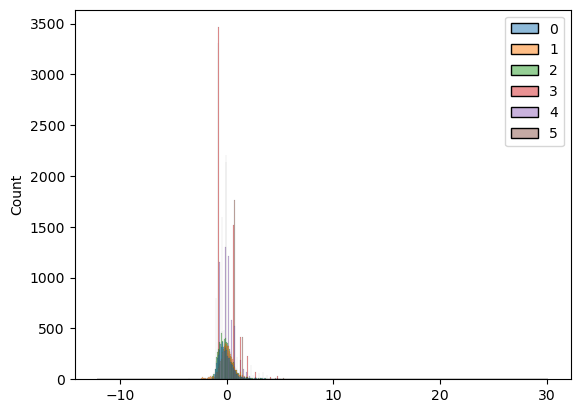

In [ ]:
import seaborn as sns

sns.histplot(X_train_std)

In [ ]:
lr = LinearRegression()

lr.fit(X_train_std, y_train)
train_pred = lr.predict(X_train_std) 
#print('Training accuracy:', mean_squared_error(y_train, train_pred))

test_pred = lr.predict(X_test_std) 
#print('Testing accuracy:', mean_squared_error(y_test, test_pred)) 
lr_r2_train=mean_squared_error(y_train, train_pred)
lr_rmse_train=math.sqrt(lr_r2_train)
lr_r2_test=mean_squared_error(y_test, test_pred)
lr_rmse_test=math.sqrt(lr_r2_test)

svr = SVR()
svr.fit(X_train_std, y_train)

pred_svr_train=svr.predict(X_train_std)
pred_svr_test=svr.predict(X_test_std)

svr_r2_train=mean_squared_error(y_train, pred_svr_train)
svr_rmse_train=math.sqrt(svr_r2_train)
svr_r2_test=mean_squared_error(y_test, pred_svr_test)
svr_rmse_test=math.sqrt(svr_r2_test)

print("Linear Regression\n\n", "Train R^2:", lr_r2_train, "\n Test R^2:", lr_r2_test)
print(" RMSE train:", lr_rmse_train, "\n RMSE test:'", lr_rmse_test)
print("\nSVR\n", "Train R^2:", svr_r2_train, "\n Test R^2:", svr_r2_test)
print(" RMSE train:", svr_rmse_train, "\n RMSE test:'", svr_rmse_test)

c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Regression

 Train R^2: 3.095433055608385 
 Test R^2: 2.774937341950642
 RMSE train: 1.7593842830968978 
 RMSE test:' 1.6658143179690352

SVR
 Train R^2: 1.724828423458021 
 Test R^2: 1.556033694435852
 RMSE train: 1.3133272339588564 
 RMSE test:' 1.24741079618378


In [10]:
import pickle as pkl

#save svm

with open('data/svr.pkl', 'wb') as f:
    pkl.dump(svr, f)

In [ ]:
with open('data/svr.pkl', 'rb') as f:
    svr_loaded = pkl.load(f)

svr_loaded.predict(X_test_nosmiles)

c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


array([-3.41740865, -3.41740865, -3.41740865, ..., -3.41740865,
       -3.41740865, -3.41740865])

## Exercise 4: Featurizer class (2 points)

All the data manipulations, including the generation of features (molecular descriptors) and scaling we did completely by hand. Imagine that we have a new dataset with molecules for which we want to predict the solubility. We would have to repeat all the steps we did above, which is not at all user-friendly.

Let's encapsulate all the steps in a single class called `Featurizer`. 

**Featurizer is a piece of code which takes care of extracting the features and preparing them** in such a way that they can be used as an input for a ML model. In this fashion, our featurizer will be able to take a list of SMILES strings and return a dataframe with the molecular descriptors, ready to be used in any regression model.

The `Featurizer` class should have the following methods:

1. `__init__(self, smiles)`

    The constructor method should take an array of **training set** SMILES strings as input and calculate the molecular descriptors for each molecule (in a `pandas.DataFrame`, as we did earlier). **It should also fit a scaler to the descriptors.** The descriptors should be stored in a dataframe, and the scaler should be stored as an attribute of the class.
      

2. `featurize(self, smiles)`
    
   This method should take an array of SMILES strings as input and return a dataframe with the molecular descriptors calculated with RDKit. **The descriptors should be standardized using the scaler which was fitted to the training set in the `__init__` method**.

3. **You are more than welcome to implement other methods** if you think it will make your code cleaner or more efficient. Maybe we could have a separate method for the calculation of molecular descriptors, or for the scaling of the features?


### Here is an example of how our `Featurizer` class should be used
```python
featurizer = Featurizer(X_train['SMILES'])  # Create an instance of the Featurizer class, passing the training set SMILES strings

# Say we want to predict the solubility of the following molecules
some_SMILES = ['CC(=O)Oc1ccccc1C(=O)O',     
               'C1=CC(=C(C=C1[C@H](CN)O)O)O',
               'C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O']

# Extract the features
X = featurizer.featurize(some_SMILES)

...

y_pred = model.predict(X)   # Get predictions
```


In [12]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') # Disabling rdkit warnings

class Featurizer:
    def __init__(self, train_smiles):
        self.scaler=StandardScaler()
        train_descriptors = self.get_descriptors(train_smiles)
        self.scaler.fit(train_descriptors)
        
    def featurize(self, smiles):
        descriptors = self.get_descriptors(smiles)
        scaled_descriptors = self.scaler.transform(descriptors)
        return scaled_descriptors

    def get_descriptors(self, smiles):
        df = pd.DataFrame({'SMILES': smiles})
        df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)
        df['mol_wt'] = df['mol'].apply(rdMolDescriptors.CalcExactMolWt)             # Molecular weight
        df['logp'] = df['mol'].apply(Crippen.MolLogP)                               # LogP (lipophilicity)
        df['num_heavy_atoms'] = df['mol'].apply(rdMolDescriptors.CalcNumHeavyAtoms) # Number of heavy atoms
        df['num_HBD'] = df['mol'].apply(rdMolDescriptors.CalcNumHBD)                # Number of hydrogen bond donors
        df['num_HBA'] = df['mol'].apply(rdMolDescriptors.CalcNumHBA)                # Number of hydrogen bond acceptors
        df['aromatic_rings'] = df['mol'].apply(rdMolDescriptors.CalcNumAromaticRings) 
        return df.drop(columns=['mol', 'SMILES'], axis=1)

In [13]:
print(X_train['SMILES'])

2943                                        CCCCCCCCCCC=O
7791           CC(C)COC(=O)[N]1C2=C(C=CC=C2)N=C1C3=CSC=N3
1298                   Cc1ccc(cc1)C(=O)OOC(=O)c2ccc(C)cc2
2588                                      CCCCC(CC)COCCCN
3527    CC(=O)C(N=Nc1ccc(cc1)[N+]([O-])=O)C(=O)Nc2ccc3...
                              ...                        
5734    O[P](O)(=O)CN(CCCCCCN(C[P](O)(O)=O)C[P](O)(O)=...
5191                                Cc1cc(C)c[n+]([O-])c1
5390                           CC(C)C(Br)C(=O)NC(C)C(O)=O
860                                    FC(F)=C(F)C(F)(F)F
7270                         [O-][N+](=O)C1=CC=CC(=C1)C=O
Name: SMILES, Length: 7984, dtype: object


In [ ]:
# Test your featurizer
print(X_train['SMILES'])

featurizer = Featurizer(X_train['SMILES']) # Pass the training set SMILES strings to the constructor

import pandas as pd

tryptamines = pd.read_csv('data/tryptamines.csv')   # Load a new dataset
tryptamines.head()

2943                                        CCCCCCCCCCC=O
7791           CC(C)COC(=O)[N]1C2=C(C=CC=C2)N=C1C3=CSC=N3
1298                   Cc1ccc(cc1)C(=O)OOC(=O)c2ccc(C)cc2
2588                                      CCCCC(CC)COCCCN
3527    CC(=O)C(N=Nc1ccc(cc1)[N+]([O-])=O)C(=O)Nc2ccc3...
                              ...                        
5734    O[P](O)(=O)CN(CCCCCCN(C[P](O)(O)=O)C[P](O)(O)=...
5191                                Cc1cc(C)c[n+]([O-])c1
5390                           CC(C)C(Br)C(=O)NC(C)C(O)=O
860                                    FC(F)=C(F)C(F)(F)F
7270                         [O-][N+](=O)C1=CC=CC(=C1)C=O
Name: SMILES, Length: 7984, dtype: object


,SMILES,Name
0,C1=CC=C2C(=C1)C(=CN2)CCN,Tryptamine
1,CNS(=O)(=O)CC1=CC2=C(NC=C2CCN(C)C)C=C1,Sumatriptan
2,CC(C)N(CCC1=CNC2=CC=CC=C21)C(C)C,DiPT
3,CC(=O)NCCC1=CNC2=C1C=C(C=C2)OC,Melatonin
4,NC(C)CC1=CNC2=C1C=CC=C2,AMT


In [15]:
import pickle as pkl

#save svm

with open('data/feat.pkl', 'wb') as f:
    pkl.dump(featurizer, f)

In [16]:
X = featurizer.featurize(tryptamines['SMILES'])   # Extract features for the new dataset
X

array([[-0.57369646, -0.08568122, -0.43469279,  0.62003607, -0.7091435 ,
         0.72085111],
       [ 0.15481192, -0.18397256,  0.21515385,  0.62003607, -0.13608665,
         0.72085111],
       [-0.1200146 ,  0.5246066 ,  0.05269219, -0.06933421, -0.7091435 ,
         0.72085111],
       [-0.18514652, -0.03313109, -0.02853864,  0.62003607, -0.42261507,
         0.72085111],
       [-0.49808282,  0.02408075, -0.35346196,  0.62003607, -0.7091435 ,
         0.72085111],
       [-0.4874048 , -0.16885733, -0.35346196,  1.30940635, -0.42261507,
         0.72085111]])

In [17]:
# Predict the solubility of the new molecules

y_pred = svr.predict(X)  # Use the linear regression model to predict the solubility

tryptamines['Solubility'] = y_pred  # Add the predictions to the dataframe
tryptamines.head()

,SMILES,Name,Solubility
0,C1=CC=C2C(=C1)C(=CN2)CCN,Tryptamine,-2.254795
1,CNS(=O)(=O)CC1=CC2=C(NC=C2CCN(C)C)C=C1,Sumatriptan,-2.597183
2,CC(C)N(CCC1=CNC2=CC=CC=C21)C(C)C,DiPT,-4.150095
3,CC(=O)NCCC1=CNC2=C1C=C(C=C2)OC,Melatonin,-2.760975
4,NC(C)CC1=CNC2=C1C=CC=C2,AMT,-2.518150


## Cross-validation and grid search

Now that we have a working regression model, we can try to improve its performance by tuning the hyperparameters. Last time we tuned the hyperparameters by hand, but as you may guess, that is not the most efficient way to do it. What we can (and will) do is employ a **search algorithm** to find the best hyperparameters automatically. This piece of code will try different hyperparameters and return the best combination.

Last time we introduced the concept of a **validation set**, which is a subset of the training set used to evaluate the model's performance during hyperparameter tuning. To tune the hyperparameters of a classifier model we cut out a part of the training set and used the accuracy on this validation set as a metric to evaluate the model's performance.

In practice, when tuning hyperparameters of a machine learning model, we do not usually create a single validation set. Instead, we employ a srategy called **cross-validation**. In $k$-fold cross-validation, the process of training and evaluating the model is repeated $k$ times, with each repetition using a different validation set. Thanks to this strategy, each data point present in the original training set will have the chance to be included in a validation sets. The metrics reported from $k$ folds are then averaged to get a more reliable estimate of the model's performance.

<center>
<img src="imgs/cross-validation.png" width="800">
</center>

Luckily, we do not have to implement this algorithm ourselves, as scikit-learn provides a `GridSearchCV` class that can help us with this task. It performs an exhaustive search over a specified parameter grid and evaluates the model's performance using $k$-fold cross-validation. By default, `GridSearchCV` uses a 5-fold cross-validation, which is a common choice for $k$.

In [ ]:
from sklearn.model_selection import GridSearchCV

svr = SVR()

# We will define a grid of hyperparameters as a dictionary. The keys are the hyperparameter names, and the values are lists of possible values to try.

param_grid = {
    'C': [1, 5, 10, 20, 50, 100],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(
    svr, # the model
    param_grid, # the grid of hyperparameters
    verbose=2 # print the progress
)

svr = grid_search.fit(X_train_nosmiles, y_train) # GridSearchCV.fit() returns the best model, and we can save it to a new variable

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=1, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=1, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=1, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=1, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=1, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=1, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=1, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=1, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=1, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=1, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=1, epsilon=0.5; total time=   1.3s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=1, epsilon=1; total time=   0.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=1, epsilon=1; total time=   0.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=1, epsilon=1; total time=   0.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=1, epsilon=1; total time=   0.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=1, epsilon=1; total time=   0.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=5, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=5, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=5, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=5, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=5, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=5, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=5, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=5, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=5, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=5, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=5, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=5, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=5, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=5, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=5, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................C=5, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=10, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=10, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=10, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=10, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=10, epsilon=0.001; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=10, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=10, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=10, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=10, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=10, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=10, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=10, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=10, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=10, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=10, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=10, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=20, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=20, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=20, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=20, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=20, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=20, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=20, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=20, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=20, epsilon=0.01; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=20, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.1; total time=   1.5s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=20, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=20, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=20, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=20, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=20, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=20, epsilon=1; total time=   0.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=50, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=50, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=50, epsilon=0.001; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=50, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=50, epsilon=0.001; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=50, epsilon=0.01; total time=   1.9s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=50, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=50, epsilon=0.01; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=50, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=50, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.1; total time=   1.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.5; total time=   1.1s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................................C=50, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=50, epsilon=1; total time=   0.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=50, epsilon=1; total time=   0.6s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=50, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=50, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................................C=50, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............................C=100, epsilon=0.001; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............................C=100, epsilon=0.001; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............................C=100, epsilon=0.001; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............................C=100, epsilon=0.001; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...............................C=100, epsilon=0.001; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=100, epsilon=0.01; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=100, epsilon=0.01; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=100, epsilon=0.01; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=100, epsilon=0.01; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................................C=100, epsilon=0.01; total time=   1.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.1; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.1; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.1; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.1; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.1; total time=   1.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................................C=100, epsilon=0.5; total time=   1.2s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=100, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=100, epsilon=1; total time=   0.8s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=100, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=100, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................................C=100, epsilon=1; total time=   0.7s


c:\Users\Joanna\anaconda3\envs\pum\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
from sklearn.metrics import mean_squared_error

# Report the best hyperparameters and RMSE on the testing set

print('Best hyperparameters:', svr.get_params())

y_pred = svr.predict(X_test)

print('-'*50)
print('Testing set rmse:', mean_squared_error(y_test, y_pred))

Best hyperparameters: {'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__cache_size': 200, 'estimator__coef0': 0.0, 'estimator__degree': 3, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVR(), 'n_jobs': None, 'param_grid': {'C': [1, 5, 10, 20, 50, 100], 'epsilon': [0.001, 0.01, 0.1, 0.5, 1]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 2}


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- SMILES


### *Randomized search

`RandomizedSearchCV` is an alternative to `GridSearchCV`. Instead of trying all possible combinations of fixed hyperparameters, it samples a fixed number of hyperparameter settings from specified probability distributions. Although you may be hesitant to use it, as it is not an exhaustive search, it is often more efficient than grid search. Randomized search is especially useful when we have many hyperparameters to tune, and we are not sure which ones are the most important. Take a look at the figure below and try to understand why this is the case.

<center>
<img src="imgs/grid-vs-random.png", width="600">
</center>

Randomized search is implemented in the same way as grid search, but with a different class. It also requires a dictionary of hyperparameters, but instead of specifying a list of values to try, we specify a **probability distribution**. See the example below:

```python
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions = {
    'some_discete_hyperparameter': np.arange(1, 10), # uniform dicrete distribution from 1 to 10
    'some_continuous_hyperparameter': uniform(0, 1), # uniform continuous distribution from 0 to 1
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=100 # number of random samples to try
)
...
```

## Saving and loading Python objects

Both the featurizer and the trained regression model can be saved to disk as Python objects using the `pickle` module. This way, we can load them later in another script without the need to retrain the model or recalculate the molecular descriptors.

```python
import pickle

# Save the model

with open('path/to/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model

with open('path/to/model.pkl', 'rb') as f:
    model = pickle.load(f)

---
# Lab 4-2: Coding a simple app in Streamlit.

Streamlit is a Python library that allows you to create very nice-looking and user-friendly web applications with just a few lines of code. It is very easy to use and requires absolutely no knowledge of HTML, CSS, or JavaScript.

---

We should have Streamlit already installed in our environment. You probably should take a look at the [Streamlit documentation](https://docs.streamlit.io/library), but this is how you can run a simple Streamlit app:

Take look at `data/streamlit/app.py`. It is a tiny Streamlit app that takes a name as input and **returns a random fortune cookie-like quote**. Analyze the code and try to understand how it works. 

**Some important functions you may need to use:**

- `st.title` sets the title of the app
- `st.write` writes text to the app (supports [Markdown](https://www.markdownguide.org/basic-syntax/) synthax for text formatting)
- `st.dataframe` displays a dataframe
- `st.latex` renders LaTeX code (for mathematical formulas)
- `st.text_input` creates a text input field (for multiline inputs, use `st.text_area`)
- `st.button` creates a button (you can use it to trigger some action)

To run the app, open a terminal and run the following command:

    streamlit run data/streamlit/app.py
    
This will start a local server and open a new tab in your browser with the app. You can now interact with the app by entering your name and clicking the button to get a random fortune.

## Exercise 5: Build an app for solubility prediction (3 points)

This exercise is a continuation of the previous one. We will use all the code we have written so far to build a simple web app that predicts the solubility of molecules. The app will run in the browser and allow the user to input one or more SMILES strings, and it will display the predicted solubility of the molecules.
The [Streamlit documentation](https://docs.streamlit.io/library) will be very helpful in this task.

**The app should have the following structure:**

1. A title and a short description of what the app does.
2. A text area where the user can input a SMILES string (or multiple SMILES strings in a column).
3. A button to submit the input.
4. A section that displays the predicted solubility of the molecule(s) as a table of SMILES strings and their corresponding solubility values.

The app should use our `Featurizer` class to extract the features from the input SMILES strings and predict the solubility using the trained model. **The model and the featurizer should not be trained inside the app, but loaded from a `.pkl` file instead!** Thanks to this approach, we will not need the training data to run the app. Both the model and the featurizer are already trained and saved as Python objects.

In [ ]:
# don't train model when starting the app! Save model to a file and read it in (in the app script)
# "pickle" module comes in handy here (look into boxes right after the models)
# Featurizer też można zapisać jako pikla ( definicja klasy też musi być uwzględniona! Albo w pliku appki, albo zaimportowana)


In [ ]:
# For this exercise, you should create a new Python script called in the 'data/streamlit' directory and implement the app there.